Задача 2
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

1-Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

2-Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.

3-Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

# 1) Выбор метрики

Поскольку для нас актуально посмотреть верхнюю границу нагрузки на сервер. Нам стоит взять именно часовой интервал графика для оценки пиковой нагрузки на сервера. Показатель активности возму - общее число лайков и просмотров пользователей. Для коррелирующей величины возьму количество уникальных уникальных пользователей. 

У нас в датасете присутствует время флешмоба в котором активность пользователей возрастала. Учитывать этот факт при общете не буду, т.к. не понятно, будут ли проводится такие эвенты в будушем. Поэтому для избежания непредвиденного отключения серверов стоит закладывать большую мощность и доверительные интервалы.

# 2) Построение модели

In [25]:
#Подключаем библиотеки
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
from orbit.diagnostics.metrics import rmsse


import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [2]:
#Параметры подлючения
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
#Запрос
query = '''
SELECT 
    toStartOfHour(time) as hours,
    count(user_id) AS  actions,
    count(distinct user_id) AS users
FROM simulator_20230920.feed_actions
WHERE time < today() - 1
GROUP BY hours
ORDER BY hours ASC 
'''

activity = ph.read_clickhouse(query=query, connection=connection)
activity.head()

,hours,actions,users
0,2023-08-02 00:00:00,22,14
1,2023-08-02 01:00:00,32,26
2,2023-08-02 02:00:00,24,16
3,2023-08-02 03:00:00,11,11
4,2023-08-02 04:00:00,18,14


In [4]:
#Проверим корреляцию между параметрами
activity.corr()

,hours,actions,users
hours,1.000000,0.635573,0.699688
actions,0.635573,1.000000,0.822989
users,0.699688,0.822989,1.000000


In [5]:
#Как и ожидалось, обнаружена сильная корреляция, около 0,7

Модели будем строить по 3 алгоритмам stan-map, stan-mcmc. С регрессорами и без них

# stan-map без регрессора

In [6]:
#Сначало проверим алгоритмы предсказывания на имеющихся данных 
#для этого возьмем в качестве предсказания последнии 14 дней 

train_data = activity[activity['hours'] < '2023-09-28 00:00:00']
test_data = activity[activity['hours'] >= '2023-09-28 00:00:00'].astype({"users":"int64"})

In [7]:
#Построим модель
dlt_map_model = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000
               ) 

dlt_map_model.fit(train_data)

2023-10-13 11:57:04 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

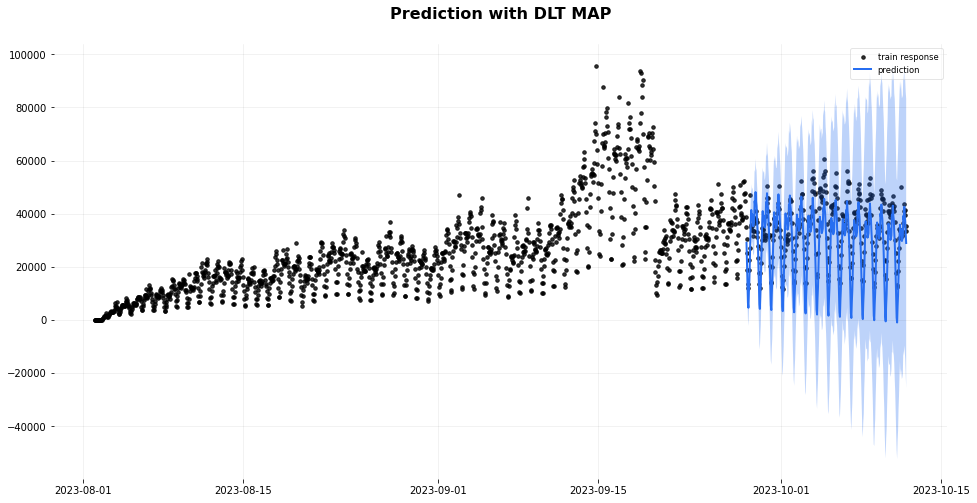

In [8]:
predicted_df_map = dlt_map_model.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_map, "hours", 'actions', title='Prediction with DLT MAP')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

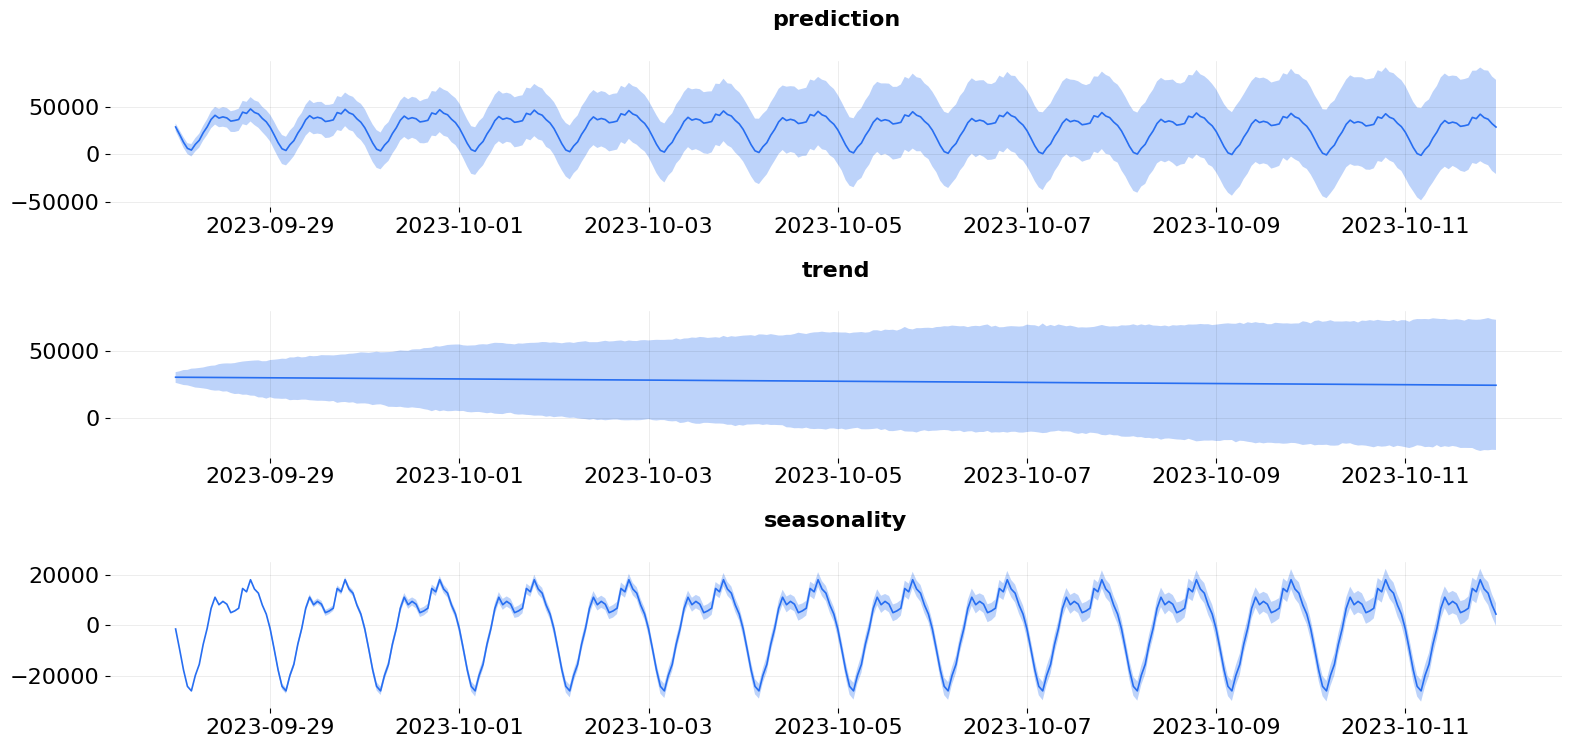

In [9]:
predicted_df_map = dlt_map_model.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df_map, "hours", plot_components=['prediction', 'trend', 'seasonality'])

# stan-mcmc без регрессора

In [20]:
 dlt_mcmc_model = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-mcmc", 
                num_warmup=2000,
                num_sample=1000
               ) 

dlt_mcmc_model.fit(train_data)

2023-10-13 12:16:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

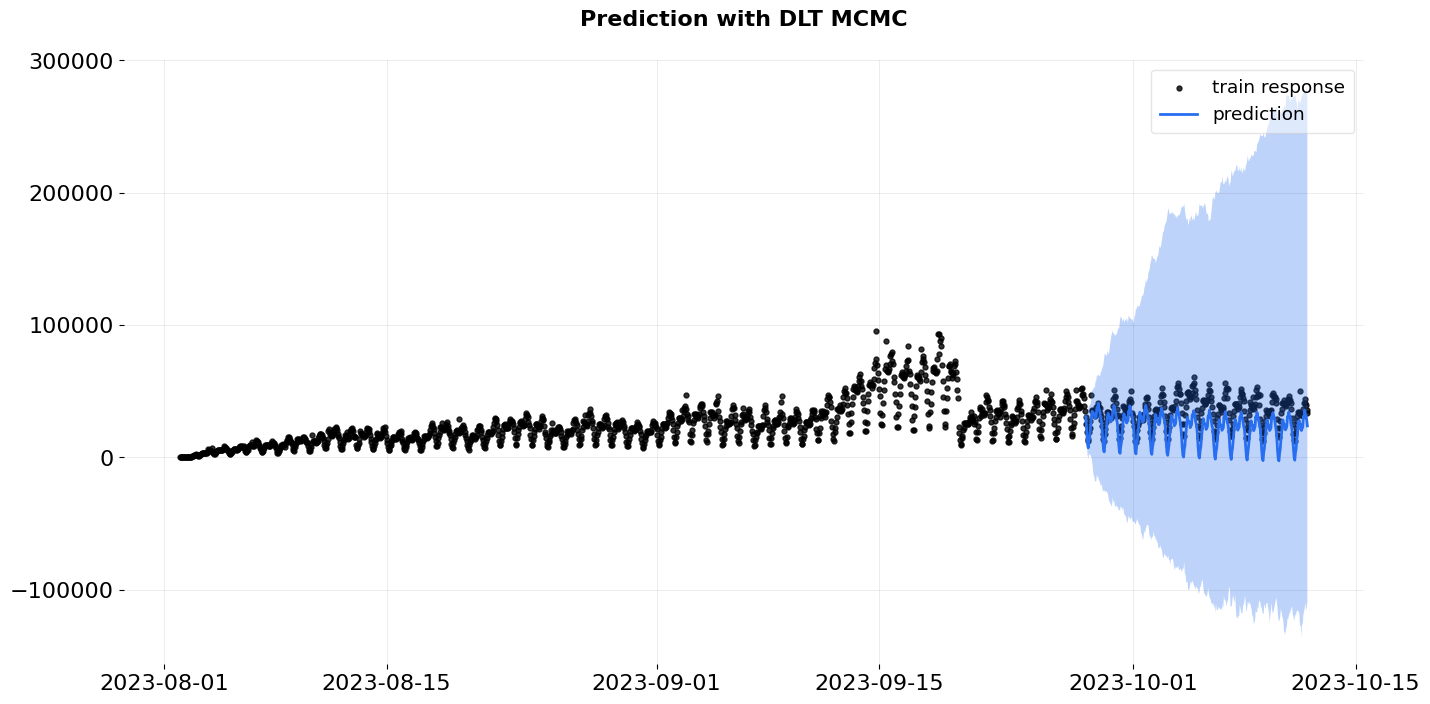

In [23]:
 predicted_df_mcmc = dlt_mcmc_model.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_mcmc, "hours", 'actions', title='Prediction with DLT MCMC')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

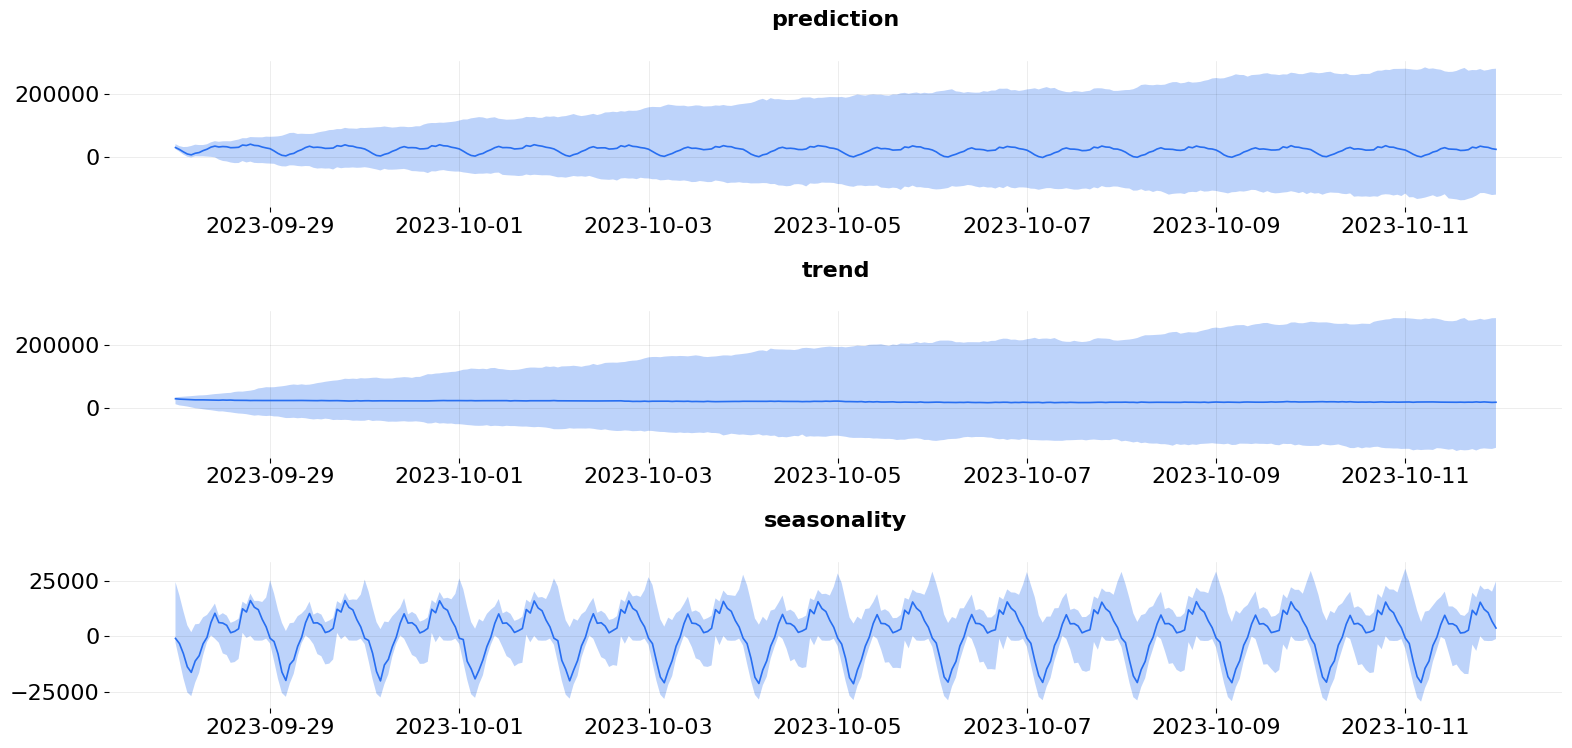

In [32]:
predicted_df_mcmc = dlt_mcmc_model.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df_mcmc, "hours", plot_components=['prediction', 'trend', 'seasonality'])

# stan-map c регрессором

In [18]:
 dlt_map_reg_model = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["users"]
               ) 

dlt_map_reg_model.fit(train_data)

2023-10-13 12:15:34 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

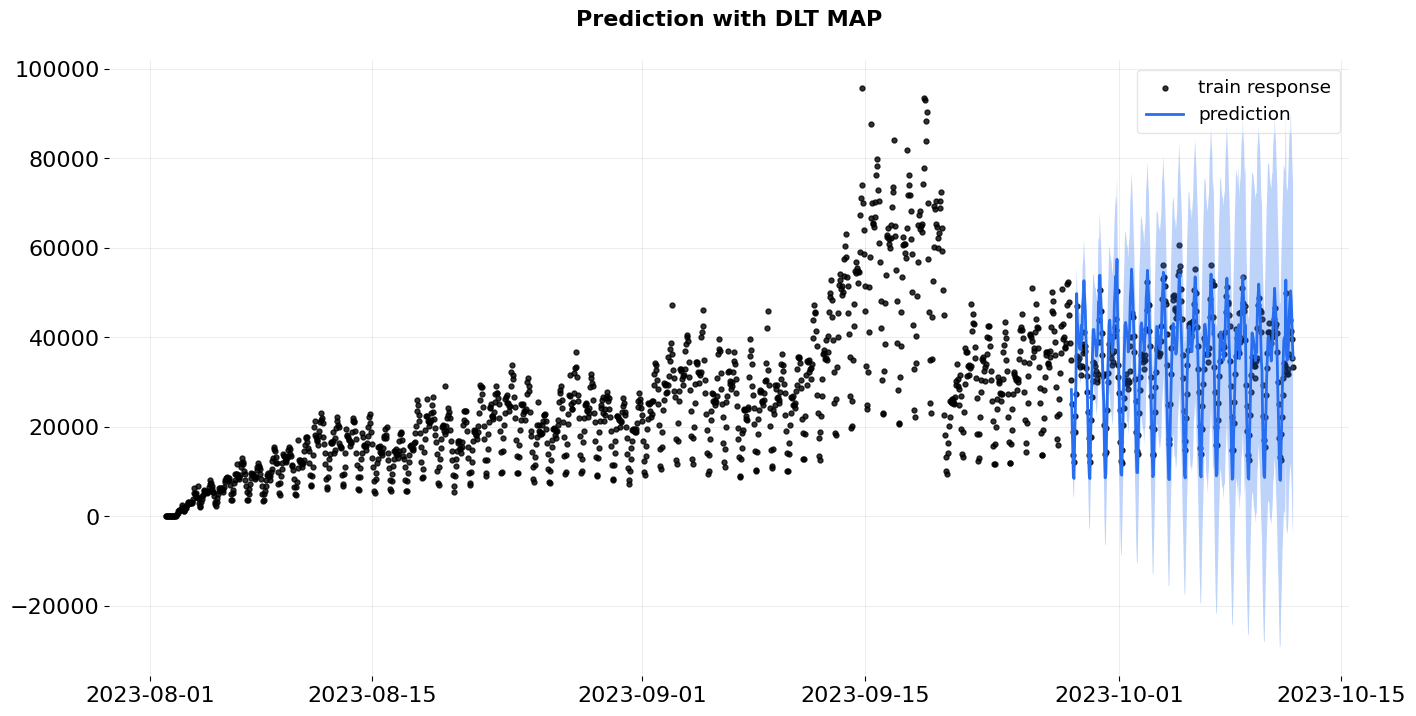

In [29]:
predicted_df_map_reg = dlt_map_reg_model.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_map_reg, "hours", 'actions', title='Prediction with DLT MAP')

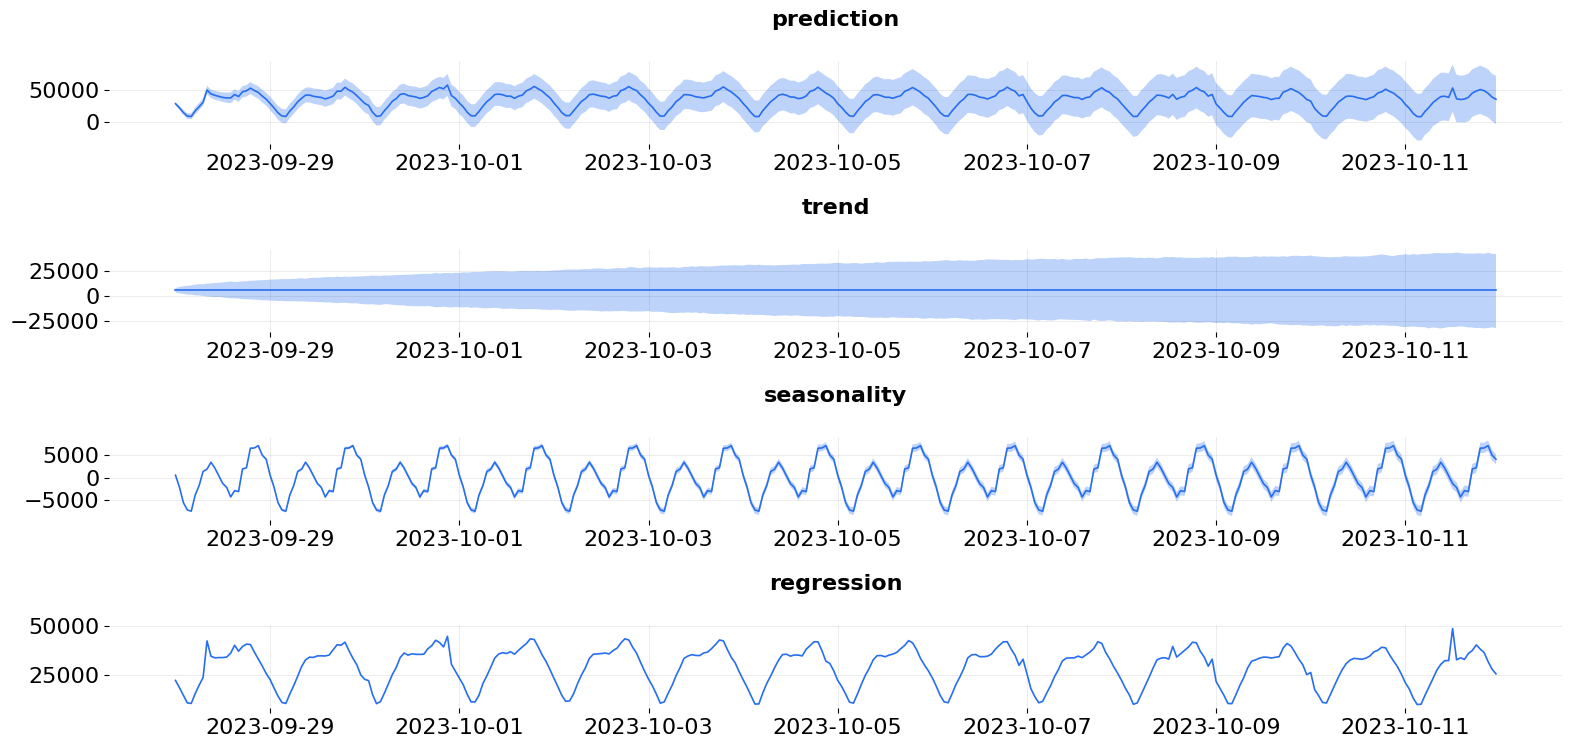

In [32]:
predicted_df = dlt_map_reg_model.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df, "hours", plot_components=['prediction', 'trend', 'seasonality', "regression"])

# stan-mcmc с регрессором

In [21]:
 dlt_mcmc_reg_model = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-mcmc", 
                num_warmup=2000,
                num_sample=1000,
                regressor_col=["users"]
               ) 

dlt_mcmc_reg_model.fit(train_data)

2023-10-13 12:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

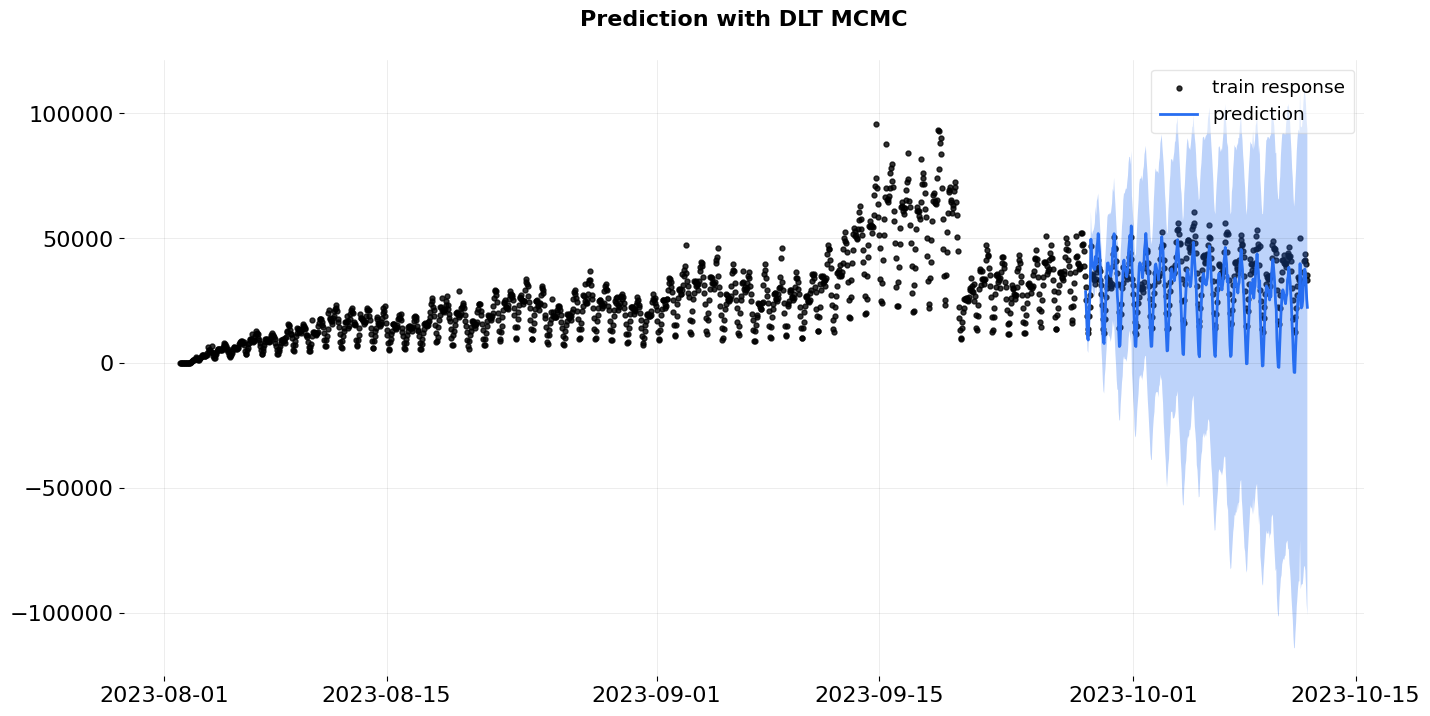

In [31]:
predicted_df_mcmc_reg = dlt_mcmc_reg_model.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_mcmc_reg, "hours", 'actions', title='Prediction with DLT MCMC')

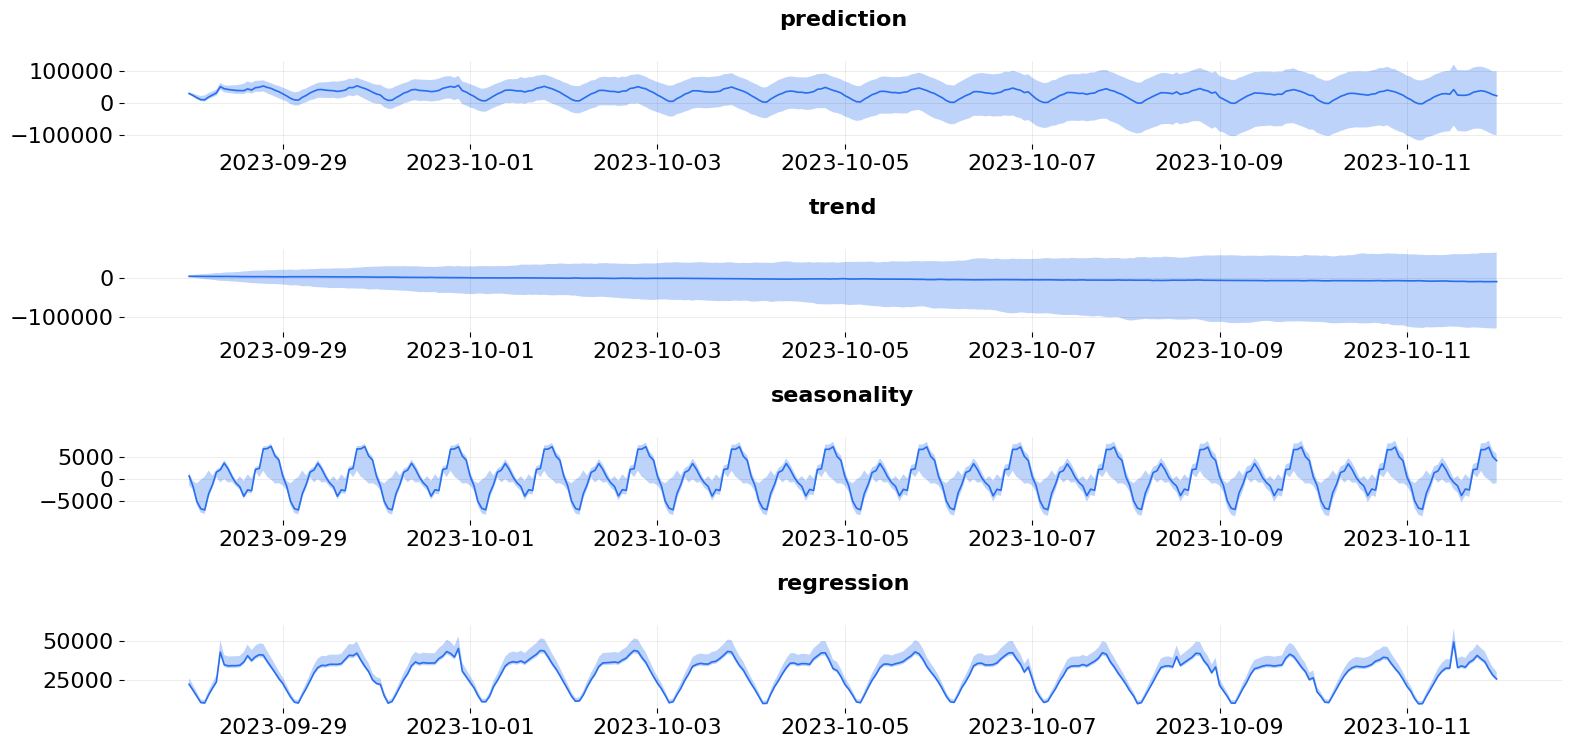

In [35]:
predicted_df = dlt_mcmc_reg_model.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df, "hours", plot_components=['prediction', 'trend', 'seasonality', "regression"])

# Оцениваем модели

In [33]:
# Проверим RMSE моделей

print(f"stan-map без регрессора: {rmsse(test_data['actions'].values, predicted_df_map.prediction.values, train_data['actions'].values)}")
print(f"stan-mcmc без регрессора: {rmsse(test_data['actions'].values, predicted_df_map_reg.prediction.values, train_data['actions'].values)}")
print(f"stan-map c регрессором: {rmsse(test_data['actions'].values, predicted_df_mcmc.prediction.values, train_data['actions'].values)}")
print(f"stan-mcmc с регрессором: {rmsse(test_data['actions'].values, predicted_df_mcmc_reg.prediction.values, train_data['actions'].values)}")

stan-map без регрессора: 1.770083160954707
stan-mcmc без регрессора: 1.0483995871608458
stan-map c регрессором: 2.565128562921005
stan-mcmc с регрессором: 1.8596753543761702


Самый маленький показатель RMSSE у алгоритма stan-mcmc без регрессора

# stan-mcmc без регрессора с auto_ridge

In [53]:
dlt_mcmc_model_auto_ridge = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-mcmc", 
                num_warmup=2000,
                num_sample=1000,
                regression_penalty= "auto_ridge"
               ) 

dlt_mcmc_model_auto_ridge.fit(train_data)

2023-10-13 13:13:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

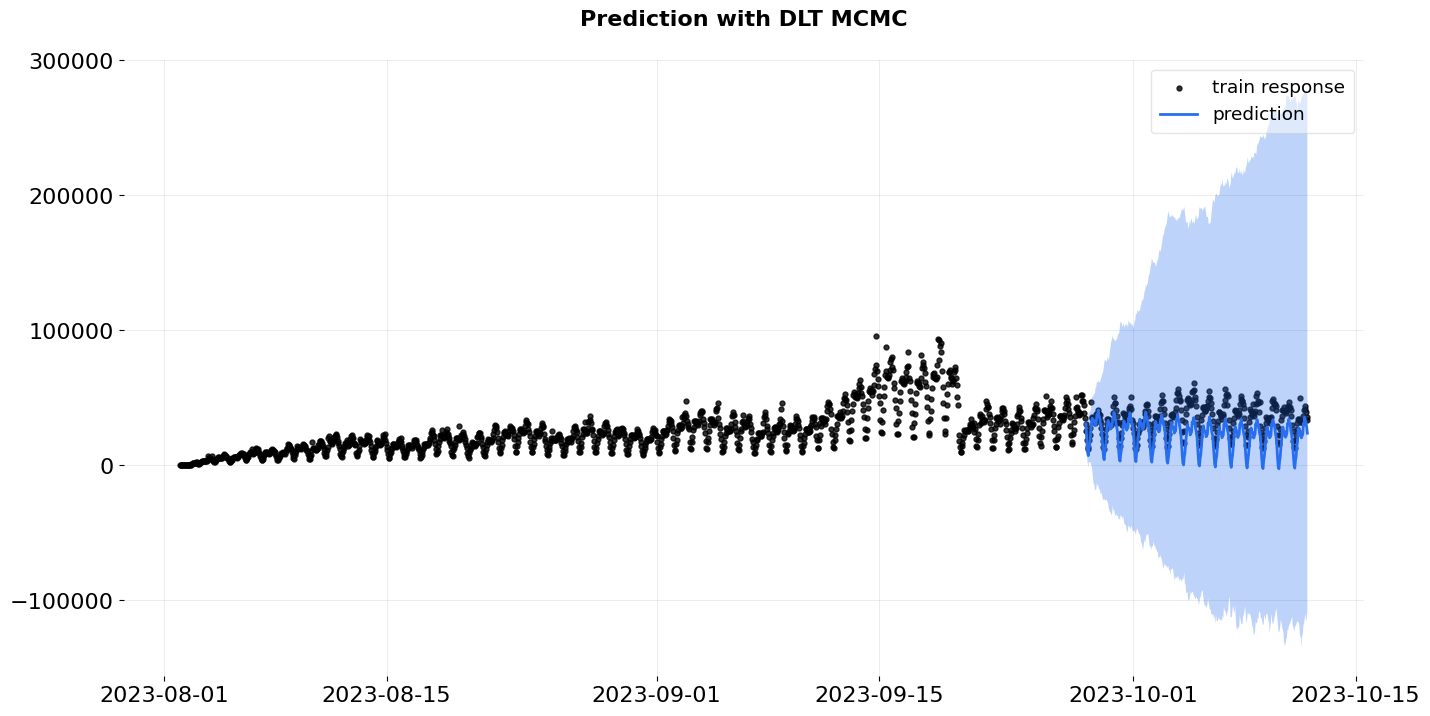

In [54]:
predicted_df_mcmc_auto_ridge = dlt_mcmc_model_auto_ridge.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_mcmc_auto_ridge, "hours", 'actions', title='Prediction with DLT MCMC')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

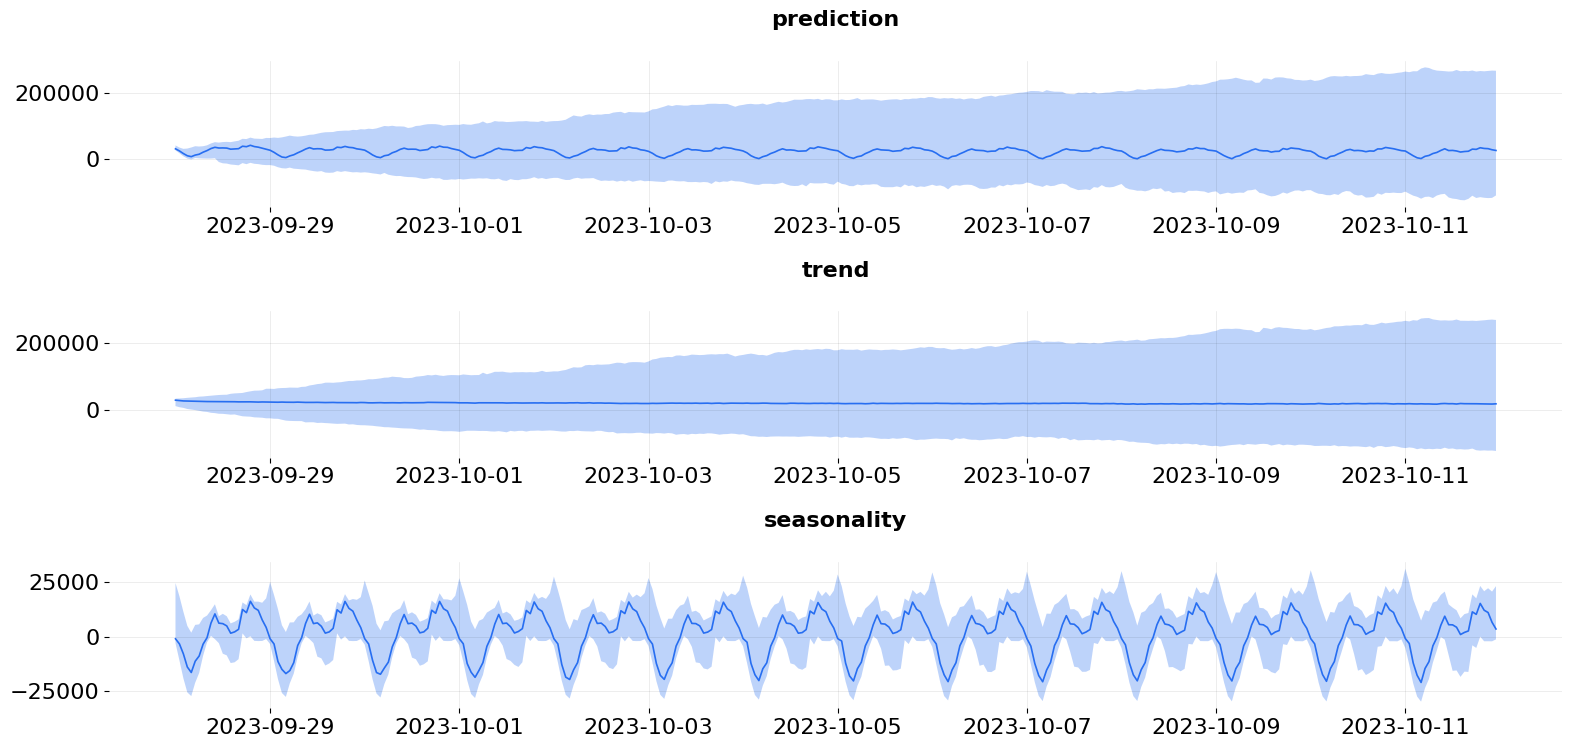

In [55]:
predicted_df_mcmc_auto_ridge = dlt_mcmc_model_auto_ridge.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df_mcmc_auto_ridge, "hours", plot_components=['prediction', 'trend', 'seasonality'])

In [56]:
#Посмотрим его показатель RMSSE
print(f"stan-mcmc без регрессора: {rmsse(test_data['actions'].values, predicted_df_mcmc_auto_ridge.prediction.values, train_data['actions'].values)}")

stan-mcmc без регрессора: 2.594037042695138


C auto_ridge результат получился хуже

# Подберем лучшие параметры

Попробуем так же подобрать лучшие параметры  и для быстроты процесса будем тспользовать stan-map без регрессора

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid={"regression_penalty": ["auto_ridge","lasso"],
                                                      "damped_factor": np.arange(0.2, 0.9, 0.3)
                                                     }, #наш параметр
                                        model=dlt_map_model,
                                        df=activity,
                                        min_train_len=24*20,
                                        incremental_len=24*10,
                                        forecast_len=24*10,
                                        metrics=None, #смотрим smape по умолчанию
                                        criteria="min", #говорим, что нам нужна минимизация
                                        verbose=True) #пусть печатает процесс выполнения

  0%|          | 0/6 [00:00<?, ?it/s]

2023-10-13 12:47:58 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'regression_penalty': 'auto_ridge'}
2023-10-13 12:47:58 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-13 12:48:06 - orbit - INFO - tuning metric:0.39404
2023-10-13 12:48:06 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'regression_penalty': 'lasso'}
2023-10-13 12:48:06 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-13 12:48:13 - orbit - INFO - tuning metric:0.39404
2023-10-13 12:48:13 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5, 'regression_penalty': 'auto_ridge'}
2023-10-13 12:48:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-13 12:48:20 - orbit - INFO - tuning metric:0.37497
2023-10-13 12:48:20 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5, 'regression_penalty': 'lasso'}
2023-10-13 12:48:20 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-13 12:48:27 - orbit - INFO - tuning metri

In [41]:
#Посмотрим на результаты
tuned_df

,damped_factor,regression_penalty,metrics
0,0.2,auto_ridge,0.394041
1,0.2,lasso,0.394041
2,0.5,auto_ridge,0.374966
3,0.5,lasso,0.374966
4,0.8,auto_ridge,0.345336
5,0.8,lasso,0.345336


Самое наилучшее значение в при damped_factor = 0.8 и auto_ridge 0.345336. Подставим эти значения в stan-mcmc без регрессора

In [59]:
dlt_map_model_best = DLT(response_col="actions",
                date_col="hours", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000,
                damped_factor = 0.8,
                regression_penalty="auto_ridge" 
               ) 

dlt_map_model_best.fit(train_data)

2023-10-13 13:20:57 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


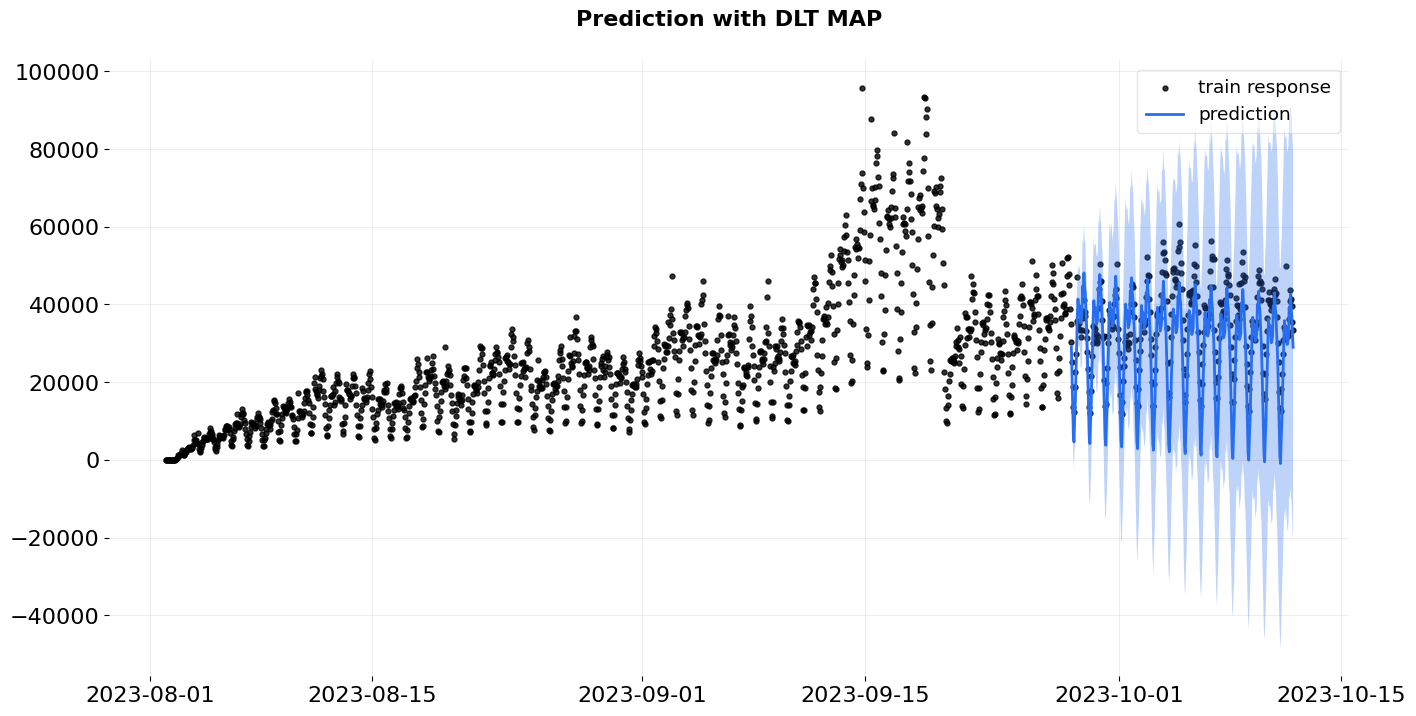

In [61]:
predicted_df_map_best = dlt_map_model_best.predict(df=test_data)

_ = plot_predicted_data(activity, predicted_df_map_best, "hours", 'actions', title='Prediction with DLT MAP')

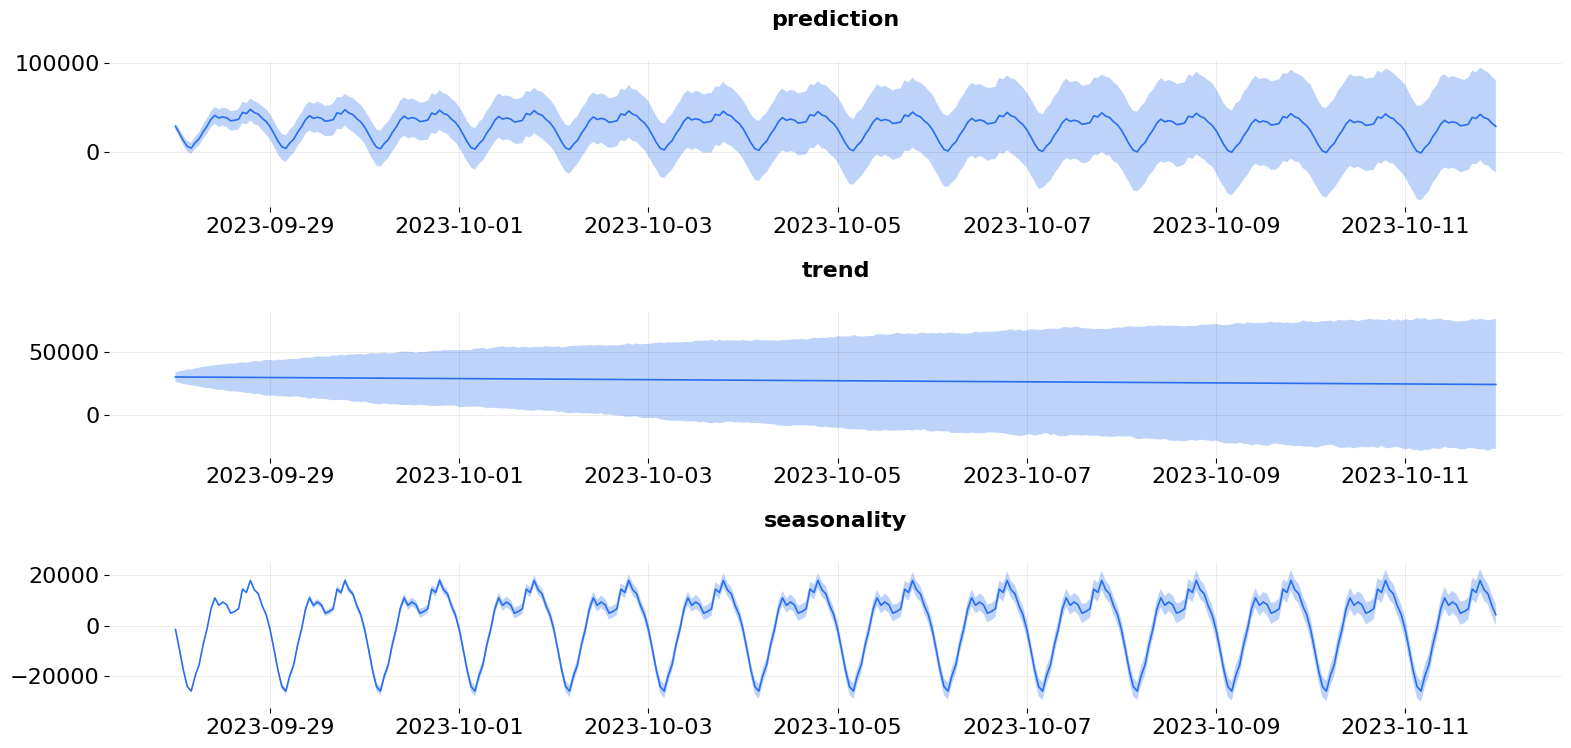

In [63]:
predicted_df_map_best  = dlt_map_model_best.predict(df=test_data, decompose=True)
_ = plot_predicted_components(predicted_df_map_best , "hours", plot_components=['prediction', 'trend', 'seasonality'])

In [64]:
print(f"stan-map без регрессора c лучшими параметрами: {rmsse(test_data['actions'].values, predicted_df_map_best.prediction.values, train_data['actions'].values)}")

stan-map без регрессора c лучшими параметрами: 1.770083160954707


# Итог по выбору модели

По итогу будем применять модель stan-mcmc без регрессора для наших данных

# Бэктестинг

т.к. наш продукт работает только пара месяцев, то мы не сможем предугадать показали на весь ближайший месяц, максиммум недели 2. обычно соотношение 80% на 20%.

In [68]:
# Предскажем кол-во пользователей на ближайший месяц

users_model = DLT(response_col="users",
                date_col="hours", 
                seasonality=24,
                estimator="stan-mcmc", 
                num_warmup=2000,
                num_sample=1000
               ) 

users_model.fit(activity)
future_df_users = users_model.make_future_df(periods=24*30) 

2023-10-13 13:35:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [75]:
predicted_users = users_model.predict(df=future_df_users)
predicted_users = predicted_users.drop(columns=['prediction_5', 'prediction_95']).rename(columns={'prediction':'users'})

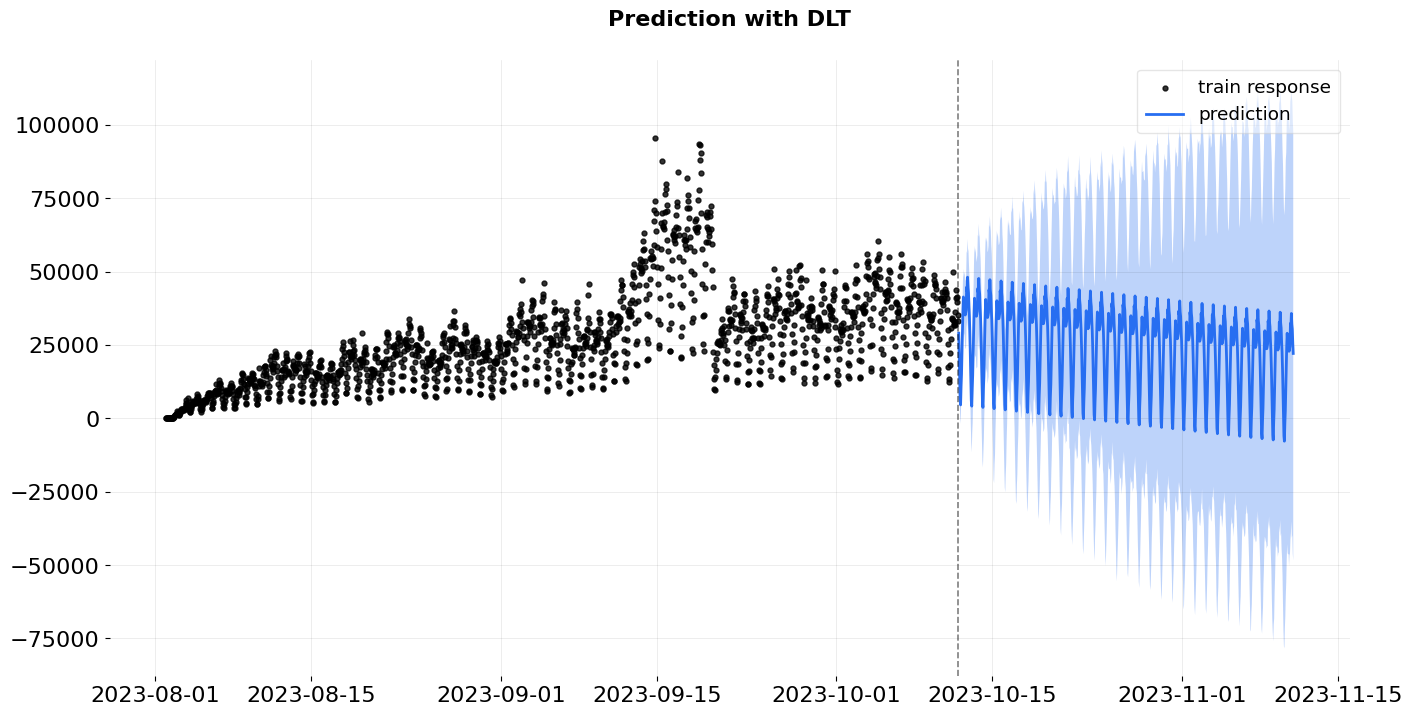

In [79]:
#Посмотрим график прогноза
predicted_df = dlt_map_model.predict(df=predicted_users)
_ = plot_predicted_data(activity, predicted_df, "hours", 'actions', title='Prediction with DLT') 

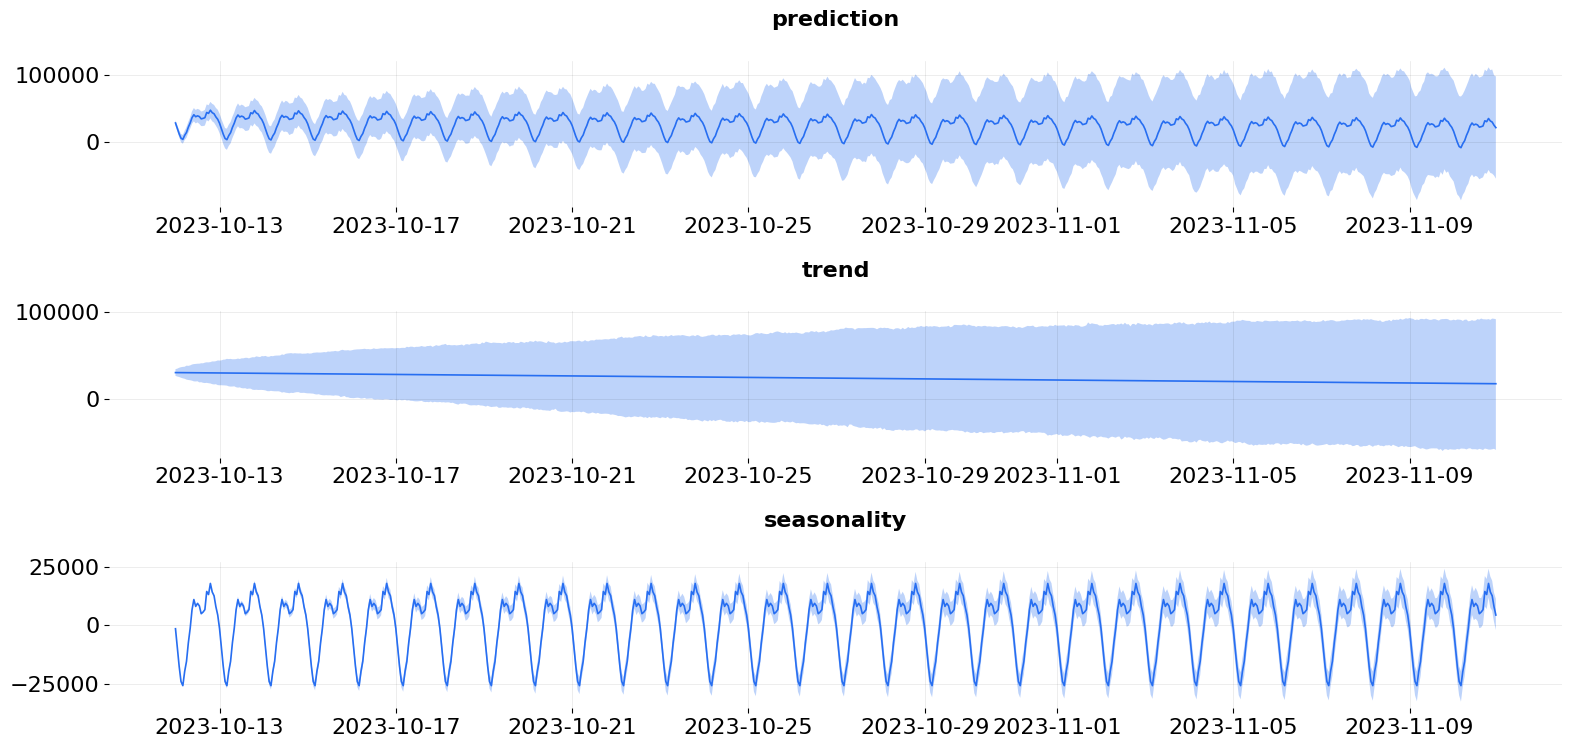

In [82]:
predicted_df = dlt_map_model.predict(df=predicted_users, decompose=True)
_ = plot_predicted_components(predicted_df, "hours", plot_components=['prediction', 'trend', 'seasonality'])

# Вывод

Основываясь на графике можно сказать что в ближайшие 2 недели рост числа пользователей не будет превышать значений которые были в переод флешмоба. По поводу прогноза на месяц сказать границы точнее уже сложно.